# CVXPY 1.4.2

https://cvxpy.org

https://github.com/cvxpy/cvxpy

CVXPY is an open source Python-embedded modeling language for convex optimization problems. It lets you express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

    conda install -c conda-forge cvxpy

# User Guide

https://www.cvxpy.org/tutorial/index.html

In [1]:
# To disable `warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)`
import warnings
warnings.filterwarnings('ignore')

## 1. What is CVXPY?

CVXPY is a Python-embedded modeling language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

In [2]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Form objective.
objective = cp.Minimize((x - y)**2)

# Create two constraints.
constraints = [x + y == 1, x - y >= 1]

# Form and solve problem.
prob = cp.Problem(objective, constraints)
prob.solve()  # Returns the optimal value.

print(f"""\
status: {prob.status}
optimal value: {prob.value}
optimal variables:
    x = {x.value}
    y = {y.value}
""")

status: optimal
optimal value: 1.0
optimal variables:
    x = 1.0
    y = 1.570086213240983e-22



### Changing the problem

Problems are immutable, meaning they cannot be changed after they are created. To change the objective or constraints, create a new problem.

In [3]:
# Replace the objective.
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print(f"optimal value: {prob2.solve()}")

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob2.constraints[1:]
prob3 = cp.Problem(prob2.objective, constraints)
print(f"optimal value: {prob3.solve()}")

optimal value: 0.9999999999945575
optimal value: 2.9999999999746754


### Infeasible and unbounded problems

If a problem is infeasible or unbounded, the status field will be set to "infeasible" or "unbounded", respectively. The value fields of the problem variables are not updated.

In [4]:
import cvxpy as cp

x = cp.Variable()

# An infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()

print(f"""\
status: {prob.status}
optimal value: {prob.value}
""")

# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()

print(f"""\
status: {prob.status}
optimal value: {prob.value}
""")

status: infeasible
optimal value: inf

status: unbounded
optimal value: -inf



### Other problem statuses

If the solver called by CVXPY solves the problem but to a lower accuracy than desired, the problem status indicates the lower accuracy achieved. The statuses indicating lower accuracy are

- "optimal_inaccurate"
- "unbounded_inaccurate"
- "infeasible_inaccurate"

The problem variables are updated as usual for the type of solution found (i.e., optimal, unbounded, or infeasible).

If the solver completely fails to solve the problem, CVXPY throws a `SolverError` exception. If this happens you should try using other solvers. See the discussion of [Choosing a solver](https://www.cvxpy.org/tutorial/advanced/index.html#solvers) for details.

CVXPY provides the following constants as aliases for the different status strings:

- `OPTIMAL`
- `INFEASIBLE`
- `UNBOUNDED`
- `OPTIMAL_INACCURATE`
- `INFEASIBLE_INACCURATE`
- `UNBOUNDED_INACCURATE`
- `INFEASIBLE_OR_UNBOUNDED`

To test if a problem was solved successfully, you would use
```
prob.status == OPTIMAL
```
The status `INFEASIBLE_OR_UNBOUNDED` is rare. It’s used when a solver was able to determine that the problem was either infeasible or unbounded, but could not tell which. You can determine the precise status by re-solving the problem where you set the objective function to a constant (e.g., `objective = cp.Minimize(0)`). If the new problem is solved with status code `INFEASIBLE_OR_UNBOUNDED` then the original problem was infeasible. If the new problem is solved with status `OPTIMAL` then the original problem was unbounded.

### Vectors and matrices

Variables can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.

In [5]:
# A scalar variable.
a = cp.Variable()

# Vector variable with shape (5,).
x = cp.Variable(5)

# Matrix variable with shape (4, 7).
A = cp.Variable((4, 7))

a, x, A

(Variable((), var112), Variable((5,), var113), Variable((4, 7), var114))

You can use your numeric library of choice to construct matrix and vector constants. For instance, if x is a CVXPY Variable in the expression `A @ x + b`, `A` and `b` could be Numpy ndarrays, SciPy sparse matrices, etc. `A` and `b` could even be different types.

Currently the following types may be used as constants:

- NumPy ndarrays
- NumPy matrices
- SciPy sparse matrices

Here’s an example of a CVXPY problem with vectors and matrices:

In [6]:
# Solves a bounded least-squares problem.

import numpy as np
import cvxpy as cp

# Problem data.
m = 10
n = 5

rng = np.random.default_rng(1)
A = rng.standard_normal((m, n))
b = rng.standard_normal(m)

# Construct the problem.
x = cp.Variable(n)

objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

print(f"""\
optimal value: {prob.solve()}
optimal variables: (a numpy ndarray)
    {x.value}
""")

optimal value: 1.716426317778556
optimal variables: (a numpy ndarray)
    [ 3.83404177e-01  9.09989000e-01  9.20222924e-02  4.93360339e-01
 -6.78466468e-22]



### Constraints

As shown in the example code, you can use `==`, `<=`, and `>=` to construct constraints in CVXPY. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints `0 <= x` and `x <= 1` mean that every entry of `x` is between 0 and 1.

If you want matrix inequalities that represent semi-definite cone constraints, see [Semidefinite matrices](https://www.cvxpy.org/tutorial/advanced/index.html#semidefinite). The section explains how to express a semi-definite cone inequality.

You <u>cannot construct</u> inequalities with `<` and `>`. Strict inequalities don't make sense in a real world setting. Also, you <u>cannot chain</u> constraints together, e.g., `0 <= x <= 1` or `x == y == 2`. The Python interpreter treats chained constraints in such a way that CVXPY cannot capture them. CVXPY will raise an exception if you write a chained constraint.

### Parameters

Parameters are symbolic representations of constants. The purpose of parameters is to change the value of a constant in a problem without reconstructing the entire problem. In many cases, solving a parametrized program multiple times can be substantially faster than repeatedly solving a new problem: after reading this section, be sure to read the tutorial on [Disciplined Parametrized Programming](https://www.cvxpy.org/tutorial/advanced/index.html#dpp) (DPP).

Parameters can be vectors or matrices, just like variables. When you create a parameter you have the option of specifying attributes such as the sign of the parameter's entries, whether the parameter is symmetric, etc. These attributes are used in [Disciplined Convex Programming](https://www.cvxpy.org/tutorial/dcp/index.html#dcp) and are unknown unless specified. Parameters can be assigned a constant value any time after they are created. The constant value must have the same dimensions and attributes as those specified when the parameter was created.

In [7]:
# Positive scalar parameter.
m = cp.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cp.Parameter(5)

# Matrix parameter with negative entries.
G = cp.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -np.ones((4, 7))

m, c, G

(Parameter((), nonneg=True), Parameter((5,)), Parameter((4, 7), nonpos=True))

You can initialize a parameter with a value. The following code segments are equivalent:

In [8]:
# Create parameter, then assign value.
rho = cp.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cp.Parameter(nonneg=True, value=2)

Computing trade-off curves is a common use of parameters. The example below computes a trade-off curve for a LASSO problem.

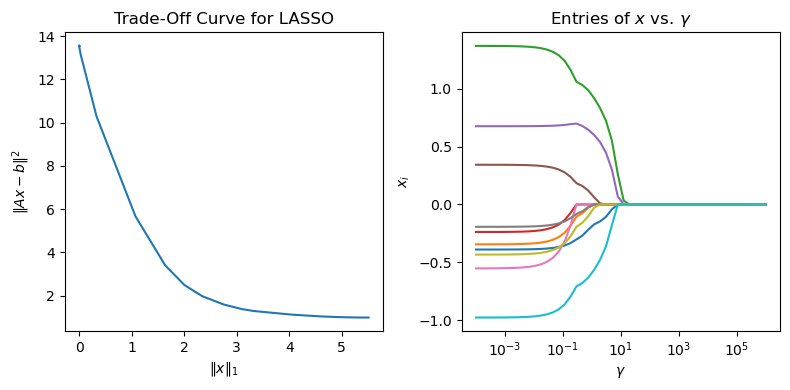

In [9]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10

rng = np.random.default_rng(1)
A = rng.standard_normal((n, m))
b = rng.standard_normal(n)

# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

# Construct the problem.
x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)

objective = cp.Minimize(error + gamma * cp.norm(x, p=1))
prob = cp.Problem(objective)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []

gamma_vals = np.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cp.norm(x, p=1).value)
    x_values.append(x.value)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

# Plot trade-off curve.
ax1.plot(l1_penalty, sq_penalty)
ax1.set_xlabel("$\|x\|_1$")
ax1.set_ylabel("$\|Ax-b\|^2$")
ax1.set_title("Trade-Off Curve for LASSO")

# Plot entries of x vs. gamma.
for i in range(m):
    ax2.plot(gamma_vals, [xi[i] for xi in x_values])
ax2.set_xscale("log")
ax2.set_xlabel("$\gamma$")
ax2.set_ylabel("$x_i$")
ax2.set_title("Entries of $x$ vs. $\gamma$")

fig.tight_layout()

Trade-off curves can easily be computed in parallel. The code below computes in parallel the optimal x for each 
 in the LASSO problem above.

In [10]:
from multiprocessing import Pool

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    prob.solve()
    return x.value

# Parallel computation (set to 1 process here).
pool = Pool(processes=1)
%time x_values = pool.map(get_x, gamma_vals)

CPU times: user 2.9 ms, sys: 0 ns, total: 2.9 ms
Wall time: 73.3 ms


## 2. Disciplined Convex Programming

Disciplined convex programming (DCP) is a system for constructing mathematical expressions with known curvature from a given library of base functions. CVXPY uses DCP to ensure that the specified optimization problems are convex.

This section of the tutorial explains the rules of DCP and how they are applied by CVXPY.

Visit https://dcp.stanford.edu for a more interactive introduction to DCP.

### Expressions

Expressions in CVXPY are formed from variables, parameters, numerical constants such as Python floats and Numpy matrices, the standard arithmetic operators `+`, `-`, `*`, `/`, `@`, and a library of functions. Here are some examples of CVXPY expressions:

In [11]:
import cvxpy as cp

# Create variables and parameters.
x, y = cp.Variable(), cp.Variable()
a, b = cp.Parameter(), cp.Parameter()

# Examples of CVXPY expressions.
3.69 + b / 3

Expression(CONSTANT, UNKNOWN, ())

In [12]:
x - 4 * a

Expression(AFFINE, UNKNOWN, ())

In [13]:
cp.sqrt(x) - cp.minimum(y, x - a)

Expression(UNKNOWN, UNKNOWN, ())

In [14]:
cp.maximum(2.66 - cp.sqrt(y), cp.square(x + 2 * y))

Expression(CONVEX, NONNEGATIVE, ())

Expressions can be scalars, vectors, or matrices. The dimensions of an expression are stored as `expr.shape`. The total number of entries is given by `expr.size`, while the number of dimensions is given by `expr.ndim`. CVXPY will raise an exception if an expression is used in a way that doesn't make sense given its dimensions, for example adding matrices of different size. The semantics for how shapes behave under arithmetic operations are the same as for NumPy ndarrays (except some broadcasting is banned).

In [15]:
import numpy as np

X = cp.Variable((5, 4))
A = np.ones((3, 5))

# Use expr.shape to get the dimensions.
print(f"""
dimensions of X: {X.shape}
size of X: {X.size}
number of dimensions: {X.ndim}
dimensions of sum(X): {cp.sum(X).shape}
dimensions of A @ X: {(A @ X).shape}
""")

# ValueError raised for invalid dimensions.
try:
    A + X
except ValueError as e:
    print(e)


dimensions of X: (5, 4)
size of X: 20
number of dimensions: 2
dimensions of sum(X): ()
dimensions of A @ X: (3, 4)

Cannot broadcast dimensions  (3, 5) (5, 4)


CVXPY uses DCP analysis to determine the sign and curvature of each expression.

### Sign

Each (sub)expression is flagged as positive (non-negative), negative (non-positive), zero, or unknown.

The signs of larger expressions are determined from the signs of their subexpressions. For example, the sign of the expression `expr1 * expr2` is

- Zero if either expression has sign zero.
- Positive if `expr1` and `expr2` have the same (known) sign.
- Negative if `expr1` and `expr2` have opposite (known) signs.
- Unknown if either expression has unknown sign.

The sign given to an expression is always correct. But DCP sign analysis may flag an expression as unknown sign when the sign could be figured out through more complex analysis. For instance, `x * x` is positive but has unknown sign by the rules above.

CVXPY determines the sign of constants by looking at their value. For scalar constants, this is straightforward. Vector and matrix constants with all positive (negative) entries are marked as positive (negative). Vector and matrix constants with both positive and negative entries are marked as unknown sign.

The sign of an expression is stored as `expr.sign`:

In [16]:
x = cp.Variable()
a = cp.Parameter(nonpos=True)
c = np.array([1, -1])

print(f"""
sign of x: {x.sign}
sign of a: {a.sign}
sign of square(x): {cp.square(x).sign}
sign of c * a: {(c * a).sign}
""")


sign of x: UNKNOWN
sign of a: NONPOSITIVE
sign of square(x): NONNEGATIVE
sign of c * a: UNKNOWN



### Curvature

Each (sub)expression is flagged as one of the following curvatures (with respect to its variables)

| __Curvature__ | __Meaning__ |
| ---           | ---         |
| constant      | $f(x)$ independent of $x$ |
| affine        | $f(\theta x + (1-\theta)y) = \theta f(x) + (1-\theta)f(y)$ for all $x,y,\theta\in [0,1]$ |
| convex        | $f(\theta x + (1-\theta)y) \leq \theta f(x) + (1-\theta)f(y)$ for all $x,y,\theta\in [0,1]$ |
| concave       | $f(\theta x + (1-\theta)y) \geq \theta f(x) + (1-\theta)f(y)$ for all $x,y,\theta\in [0,1]$ |
| unknown       | DCP analysis cannot determine the curvature |

using the curvature rules given below. As with sign analysis, the conclusion is always correct, but the simple analysis can flag expressions as unknown even when they are convex or concave. Note that any constant expression is also affine, and any affine expression is convex and concave.

### Curvature rules

DCP analysis is based on applying a general composition theorem from convex analysis to each (sub)expression.

$f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is convex if $f$ is a convex function and for each $\text{expr}_i$ one of the following conditions holds:

- $f$ is increasing in argument $i$ and $\text{expr}_i$ is convex.
- $f$ is decreasing in argument $i$ and $\text{expr}_i$ is concave.
- $\text{expr}_i$ is affine or constant.

$f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is concave if $f$ is a concave function and for each $\text{expr}_i$ one of the following conditions holds:

- $f$ is increasing in argument $i$ and $\text{expr}_i$ is concave.
- $f$ is decreasing in argument $i$ and $\text{expr}_i$ is convex.
- $\text{expr}_i$ is affine or constant.

$f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is affine if $f$ is an affine function and each $\text{expr}_i$ is affine.

If none of the three rules apply, the expression $f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is marked as having unknown curvature.

Whether a function is increasing or decreasing in an argument may depend on the sign of the argument. For instance, `cp.square` is increasing for positive arguments and decreasing for negative arguments.

The curvature of an expression is stored as `expr.curvature`:

In [17]:
x = cp.Variable()
a = cp.Parameter(nonneg=True)

print(f"""
curvature of x {x.curvature}
curvature of a: {a.curvature}
curvature of square(x): {cp.square(x).curvature}
curvature of sqrt(x): {cp.sqrt(x).curvature}
""")


curvature of x AFFINE
curvature of a: CONSTANT
curvature of square(x): CONVEX
curvature of sqrt(x): CONCAVE



### Infix operators

The infix operators `+`, `-`, `*`, `/` and matrix multiplication `@` are treated exactly like functions. The infix operators `+` and `-` are affine, so the rules above are used to flag the curvature. For example, `expr1 + expr2` is flagged as convex if `expr1` and `expr2` are convex.

`expr1 * expr2`, `expr1 / expr2`, and `expr1 @ expr2` can only be DCP when one of the expressions is constant. The curvature rules above apply. For example, `expr1 / expr2` is convex when `expr1` is concave and `expr2` is negative and constant.

#### Example 1
![Example 1](https://www.cvxpy.org/_images/example1.png)

#### Example 2
![Example 2](https://www.cvxpy.org/_images/example2.png)

In [18]:
print(f"""
sqrt(1 + square(x)) curvature: {cp.sqrt(1 + cp.square(x)).curvature}
norm(hstack([1, x]), 2) curvature: {cp.norm(cp.hstack([1, x]), 2).curvature}
""")


sqrt(1 + square(x)) curvature: QUASICONVEX
norm(hstack([1, x]), 2) curvature: CONVEX



### DCP problems

A problem is constructed from an objective and a list of constraints. If a problem follows the DCP rules, it is guaranteed to be convex and solvable by CVXPY. The DCP rules require that the problem objective have one of two forms:

- Minimize(convex)
- Maximize(concave)

The only valid constraints under the DCP rules are

- affine `==` affine
- convex `<=` concave
- concave `>=` convex

You can check that a problem, constraint, or objective satisfies the DCP rules by calling `object.is_dcp()`. Here are some examples of DCP and non-DCP problems:

In [19]:
x = cp.Variable()
y = cp.Variable()

# DCP problems.
prob1 = cp.Problem(
    cp.Minimize(cp.square(x - y)),
    [x + y >= 0]
)
prob2 = cp.Problem(
    cp.Maximize(cp.sqrt(x - y)),
    [2*x - 3 == y, cp.square(x) <= 2]
)

# Non-DCP problems.

# A non-DCP objective.
objective = cp.Maximize(cp.square(x))
prob3 = cp.Problem(objective)

# A non-DCP constraint.
prob4 = cp.Problem(
    cp.Minimize(cp.square(x)),
    [cp.sqrt(x) <= 2]
)

print(f"""
prob1 is DCP: {prob1.is_dcp()}
prob2 is DCP: {prob2.is_dcp()}
prob3 is DCP: {prob3.is_dcp()}
prob4 is DCP: {prob4.is_dcp()}

Maximize(square(x)) is DCP: {objective.is_dcp()}
sqrt(x) <= 2 is DCP: {(cp.sqrt(x) <= 2).is_dcp()}
""")


prob1 is DCP: True
prob2 is DCP: True
prob3 is DCP: False
prob4 is DCP: False

Maximize(square(x)) is DCP: False
sqrt(x) <= 2 is DCP: False



CVXPY will raise an exception if you call `prob.solve()` on a non-DCP problem.

In [20]:
# A non-DCP problem.
prob = cp.Problem(cp.Minimize(cp.sqrt(x)))

try:
    prob.solve()
except Exception as e:
    print(e)

Problem does not follow DCP rules. Specifically:
The objective is not DCP, even though each sub-expression is.
You are trying to minimize a function that is concave.
However, the problem does follow DQCP rules. Consider calling solve() with `qcp=True`.


## 3. Atomic Functions

This section of the tutorial describes the atomic functions that can be applied to CVXPY expressions. CVXPY uses the function information in this section and the DCP rules to mark expressions with a sign and curvature.

### Operators

The infix operators `+`, `-`, `*`, `/`, `@` are treated as functions. The operators `+` and `-` are always affine functions. The expression `expr1 * expr2` is affine in CVXPY when one of the expressions is constant, and `expr1 / expr2` is affine when `expr2` is a scalar constant.

- `@` should be used for <u>matrix-matrix and matrix-vector multiplication</u>,
- `*` should be used for <u>matrix-scalar and vector-scalar multiplication</u>

Elementwise multiplication can be applied with the `cp.multiply` function.

#### Indexing and slicing
Indexing in CVXPY follows <u>exactly the same semantics as NumPy ndarrays</u>. For example, if `expr` has shape `(5,)` then `expr[1]` gives the second entry. More generally, `expr[i:j:k]` selects every $k$ th element of `expr`, starting at `i` and ending at `j-1`. If `expr` is a matrix, then `expr[i:j:k]` selects rows, while `expr[i:j:k, r:s:t]` selects both rows and columns. Indexing drops dimensions while slicing preserves dimensions. For example,

In [21]:
x = cp.Variable(5)

print(f"""
0 dimensional: {x[0].shape}
1 dimensional: {x[0:1].shape}
""")


0 dimensional: ()
1 dimensional: (1,)



#### Transpose
The transpose of any expression can be obtained using the syntax `expr.T`. Transpose is an affine function.

#### Power
For any CVXPY expression `expr`, the power operator `expr**p` is equivalent to the function `cp.power(expr, p)`.

### Scalar functions

A scalar function takes one or more scalars, vectors, or matrices as arguments and returns a scalar.
![](figures/dcp_scalar_functions.png)

#### Clarifications for scalar functions
The domain $\mathbf{S}^n$ refers to the set of <u>symmetric matrices</u>. The domains $\mathbf{S}^n_+$ and $\mathbf{S}^n_-$ refer to the set of <u>positive semi-definite and negative semi-definite matrices</u>, respectively. Similarly, $\mathbf{S}^n_{++}$ and $\mathbf{S}^n_{--}$ refer to the set of <u>positive definite and negative definite matrices</u>, respectively.

For a vector expression `x`, `cp.norm(x)` and `cp.norm(x, 2)` give the Euclidean norm. For a matrix expression `X`, however, `cp.norm(X)` and `cp.norm(X, 2)` give the spectral norm.

The function `cp.norm(X, "fro")` is called the Frobenius norm and `cp.norm(X, "nuc")` the nuclear norm. The nuclear norm can also be defined as the sum of `X`'s singular values.

The functions `cp.max` and `cp.min` give the largest and smallest entry, respectively, in a single expression. These functions should not be confused with `cp.maximum` and `cp.minimum` (see [Elementwise functions](https://www.cvxpy.org/tutorial/functions/index.html#elementwise)). Use `cp.maximum` and `cp.minimum` to find the max or min of a list of scalar expressions.

The CVXPY function `cp.sum` sums all the entries in a single expression. The built-in Python `sum` should be used to add together a list of expressions. For example, the following code sums a list of three expressions:

```
expr_list = [expr1, expr2, expr3]
expr_sum = sum(expr_list)
```

### Functions along an axis

The functions `cp.sum`, `cp.norm`, `cp.max`, `cp.min`, `cp.mean`, `cp.std`, `cp.var`, and `cp.ptp` can be applied along an axis. Given an `m` by `n` expression `expr`, the syntax `func(expr, axis=0, keepdims=True)` applies `func` to each column, returning a `1` by `n` expression. The syntax `func(expr, axis=1, keepdims=True)` applies `func` to each row, returning an `m` by `1` expression. By default `keepdims=False`, which means dimensions of length 1 are dropped. For example, the following code sums along the columns and rows of a matrix variable:

In [22]:
X = cp.Variable((5, 4))
col_sums_keepdims = cp.sum(X, axis=0, keepdims=True) # Has size (1, 4)
col_sums = cp.sum(X, axis=0) # Has size (4,)
row_sums = cp.sum(X, axis=1) # Has size (5,)

col_sums_keepdims, col_sums, row_sums

(Expression(AFFINE, UNKNOWN, (1, 4)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (5,)))

### Elementwise functions

These functions operate on each element of their arguments. For example, if `X` is a `5` by `4` matrix variable, then `cp.abs(X)` is a `5` by `4` matrix expression. `cp.abs(X)[1, 2]` is equivalent to `cp.abs(X[1, 2])`.

Elementwise functions that take multiple arguments, such as `cp.maximum` and `cp.multiply`, operate on the corresponding elements of each argument. For example, if `X` and `Y` are both `3` by `3` matrix variables, then `cp.maximum(X, Y)` is a `3` by `3` matrix expression. `cp.maximum(X, Y)[2, 0]` is equivalent to `cp.maximum(X[2, 0], Y[2, 0])`. This means all arguments must have the same dimensions or be scalars, which are promoted.

![](figures/dcp_elementwise_functions.png)

#### Clarifications on elementwise functions
The functions `cp.log_normcdf` and `cp.loggamma` are defined via approximations. `cp.log_normcdf` has highest accuracy over the range -4 to 4, while `cp.loggamma` has similar accuracy over all positive reals. See [CVXPY GitHub PR #1224](https://github.com/cvxpy/cvxpy/pull/1224#issue-793221374) and [CVXPY GitHub Issue #228](https://github.com/cvxpy/cvxpy/issues/228#issuecomment-544281906) for details on the approximations.

### Vector/matrix functions

A vector/matrix function takes one or more scalars, vectors, or matrices as arguments and returns a vector or matrix.

CVXPY is conservative when it determines the sign of an Expression returned by one of these functions. If any argument to one of these functions has unknown sign, then the returned Expression will also have unknown sign. If all arguments have known sign but CVXPY can determine that the returned Expression would have different signs in different entries (for example, when stacking a positive Expression and a negative Expression) then the returned Expression will have unknown sign.

![](figures/dcp_vector_matrix_functions.png)

#### Clarifications on vector and matrix functions
The input to `cp.bmat` is a list of lists of CVXPY expressions. It constructs a block matrix. The elements of each inner list are stacked horizontally and then the resulting block matrices are stacked vertically.

The output $y=\textbf{convolve}(c,x)$ has size $n+m-1$ and is defined as $y_k=\sum_{j=0}^k c[j]x[k-j]$.

The output $y=\textbf{vec}(X)$ is the matrix $X$ flattened in column-major order into a vector. Formally, $y_i=X_{i\mod m,\lfloor i/m\rfloor}$.

The output $Y=\textbf{reshape}(X,(m'n'),\texttt{order="F"})$ is the matrix $X$ cast into an $m'\times n'$ matrix. The entries are taken from $X$ in column-major order and stored in $Y$ in column-major order. Formally, $Y_{i,j}=\textbf{vec}(X)_{m',j+i}$. If `order="C"` then $X$ will be read in row-major order and $Y$ will be written to in row-major order.

The output $y=\textbf{upper\_tri}(X)$ is formed by concatenating partial rows of $X$. I.e., $y=(X[0,1\texttt{:}],X[1,2\texttt{:}],\dotsc,X[n-1,n])$.

## 4. Disciplined Geometric Programming

Disciplined geometric programming (DGP) is an analog of DCP for log-log convex functions, that is, functions of positive variables that are convex with respect to the geometric mean instead of the arithmetic mean.

While DCP is a ruleset for constructing convex programs, DGP is a ruleset for log-log convex programs (LLCPs), which are problems that are convex after the variables, objective functions, and constraint functions are replaced with their logs, an operation that we refer to as a log-log transformation. Every geometric program (GP) and generalized geometric program (GGP) is an LLCP, but there are LLCPs that are neither GPs nor GGPs.

CVXPY lets you form and solve DGP problems, just as it does for DCP problems. For example, the following code solves a simple geometric program,

In [23]:
import cvxpy as cp

# DGP requires Variables to be declared positive via `pos=True`.
x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
z = cp.Variable(pos=True)

objective = x * y * z
constraints = [
    4 * x * y * z + 2 * x * z <= 10,
    x <= 2 * y,
    y <= 2 * x,
    z >= 1
]
prob = cp.Problem(cp.Maximize(objective), constraints)
prob.solve(gp=True)

print(f"""
optimal value: {prob.value}
x: {x.value}
y: {y.value}
z: {z.value}
""")


optimal value: 1.9999999926114256
x: 0.9999999989773863
y: 1.9999999528702908
z: 1.0000000208931816



Note that to solve DGP problems, you must pass the option `gp=True` to the `solve()` method.

This section explains what DGP is, and it shows how to construct and solve DGP problems using CVXPY. At the end of the section are tables listing all the atoms that can be used in DGP problems, similar to the tables presented in the section on [DCP atoms](https://www.cvxpy.org/tutorial/functions/index.html#functions).

For an in-depth reference on DGP, see our [accompanying paper](https://web.stanford.edu/~boyd/papers/dgp.html). For interactive code examples, check out our [notebooks](https://www.cvxpy.org/examples/index.html#dgp-examples).

### Log-log curvature

Just as every Expression in CVXPY has a curvature (constant, affine, convex, concave, or unknown), every Expression also has a log-log curvature.

A function $f\colon D\subseteq\mathbb{R}^n_{++}\to\mathbb{R}$ is said to be log-log convex if the function $F(u)=\log f(e^u)$, with domain $\{u\in\mathbb{R}^n\mid e^u\in D\}$, is convex (where $\mathbb{R}^n_{++}$ denotes the set of positive reals and the logarithm and exponential are meant elementwise); the function $F$ is called the log-log transformation of $f$. The function $f$ is log-log concave if $F$ is concave, and it is log-log affine if $F$ is affine.

Every log-log affine function has the form
$$
f(x) = cx_1^{a_1}x_2^{a_2}\dotsb x_n^{a_n}
$$
where $x$ is in $\mathbb{R}^n_{++}$, the $a_i$ are real numbers, and $c$ is a positive scalar. In the context of geometric programming, such a function is called a monomial function. A sum of monomials, known as a posynomial function in geometric programming, is a log-log convex function; A table of all the [atoms with known log-log curvature](https://www.cvxpy.org/tutorial/dgp/dgp-atoms) is presented at the end of this page.

In the below table, $F$ is the log-log transformation of $f$, $u=\log x$, and $v=\log y$, where $x$ and $y$ are in the domain of $f$

![](figures/log-log_curvature.png)

CVXPY's log-log curvature analysis can flag Expressions as unknown even when they are log-log convex or log-log concave. Note that any log-log constant expression is also log-log affine, and any log-log affine expression is log-log convex and log-log concave.

The log-log curvature of an Expression is stored in its `.log_log_curvature` attribute. For example, running the following script

In [24]:
import cvxpy as cp

x = cp.Variable(pos=True)
y = cp.Variable(pos=True)

constant = cp.Constant(2.0)
monomial = constant * x * y
posynomial = monomial + (x ** 1.5) * (y ** -1)
reciprocal = posynomial ** -1
unknown = reciprocal + posynomial

constant.log_log_curvature, monomial.log_log_curvature, posynomial.log_log_curvature, \
reciprocal.log_log_curvature, unknown.log_log_curvature

('LOG-LOG CONSTANT',
 'LOG-LOG AFFINE',
 'LOG-LOG CONVEX',
 'LOG-LOG CONCAVE',
 'UNKNOWN')

You can also check the log-log curvature of an Expression by calling the methods `is_log_log_constant()`, `is_log_log_affine()`, `is_log_log_convex()`, `is_log_log_concave()`. For example, `posynomial.is_log_log_convex()` would evaluate to `True`.

### Log-log curvature rules

For an Expression to have known log-log curvature, all of the Constants, Variables, and Parameters it refers to must be elementwise positive. A Constant is positive if its numerical value is positive. Variables and Parameters are positive only if the keyword argument `pos=True` is supplied to their constructors (e.g., `x = cp.Variable(shape=(), pos=True)`). To summarize, when formulating a DGP problem, all Constants should be elementwise positive, and all Variables and Parameters must be constructed with the attribute `pos=True`.

DGP analysis is exactly analogous to DCP analysis. It is based on a library of atoms (functions) with known monotonicity and log-log curvature and a a single composition rule. The [library of atoms](https://www.cvxpy.org/tutorial/dgp/dgp-atoms) is presented at the end of this page; the composition rule is stated below.

A function $f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is log-log convex if $f$ is a log-log convex function and for each $\text{expr}_i$ one of the following conditions holds:

- $f$ is increasing in argument $i$ and $\text{expr}_i$ is log-log convex.
- $f$ is decreasing in argument $i$ and $\text{expr}_i$ is log-log concave.
- $\text{expr}_i$ is log-log affine.

A function $f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is log-log concave if $f$ is a log-log concave function and for each $\text{expr}_i$ one of the following conditions holds:

- $f$ is increasing in argument $i$ and $\text{expr}_i$ is log-log concave.
- $f$ is decreasing in argument $i$ and $\text{expr}_i$ is log-log convex.
- $\text{expr}_i$ is log-log affine.

A function $f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is log-log affine if $f$ is an log-log affine function and each $\text{expr}_i$ is log-log affine.

If none of the three rules apply, the expression $f(\text{expr}_1,\text{expr}_2,\dotsc,\text{expr}_n)$ is marked as having unknown curvature.

If an Expression satisfies the composition rule, we colloquially say that the Expression "is DGP." You can check whether an Expression is DGP by calling the method `is_dgp()`. For example, the assertions in the following code block will pass.

In [25]:
import cvxpy as cp

x = cp.Variable(pos=True)
y = cp.Variable(pos=True)

monomial = 2.0 * constant * x * y
posynomial = monomial + (x ** 1.5) * (y ** -1)

assert monomial.is_dgp()
assert posynomial.is_dgp()

An Expression is DGP precisely when it has known log-log curvature, which means at least one of the methods `is_log_log_constant()`, `is_log_log_affine()`, `is_log_log_convex()`, `is_log_log_concave()` will return `True`.

### DGP problems

A Problem is constructed from an objective and a list of constraints. If a problem follows the DGP rules, it is guaranteed to be an LLCP and solvable by CVXPY. The DGP rules require that the problem objective have one of two forms:

- Minimize(log-log convex)
- Maximize(log-log concave)

The only valid constraints under the DGP rules are

- log-log affine `==` log-log affine
- log-log convex `<=` log-log concave
- log-log concave `>=` log-log convex

You can check that a problem, constraint, or objective satisfies the DGP rules by calling `object.is_dgp()`. Here are some examples of DGP and non-DGP problems:

In [26]:
import cvxpy as cp

# DGP requires Variables to be declared positive via `pos=True`.
x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
z = cp.Variable(pos=True)

objective = x * y * z
constraints = [
    4 * x * y * z + 2 * x * z <= 10,
    x <= 2 * y,
    y <= 2 * x,
    z >= 1
]
assert objective.is_log_log_concave()
assert all(constraint.is_dgp() for constraint in constraints)

prob = cp.Problem(cp.Maximize(objective), constraints)
assert prob.is_dgp()

# All Variables must be declared as positive for an Expression to be DGP.
w = cp.Variable()
objective = w * x * y
assert not objective.is_dgp()

prob = cp.Problem(cp.Maximize(objective), constraints)
assert not prob.is_dgp()

CVXPY will raise an exception if you call `prob.solve(gp=True)` on a non-DGP problem.

### DGP atoms

This section of the tutorial describes the DGP atom library, that is, the atomic functions with known log-log curvature and monotonicity. CVXPY uses the function information in this section and the DGP rules to mark expressions with a log-log curvature. Note that every DGP expression is positive.

#### Infix operators
The infix operators `+`, `*`, `/` are treated as atoms. The operators `*` and `/` are log-log affine functions. The operator `+` is log-log convex in both its arguments.

Note that in CVXPY, `expr1 * expr2` denotes matrix multiplication when `expr1` and `expr2` are matrices; if you're running Python 3, you can alternatively use the `@` operator for matrix multiplication. Regardless of your Python version, you can also use the `cp.matmul` atom to multiply two matrices. To multiply two arrays or matrices elementwise, use the `cp.multiply` atom. Finally, to take the product of the entries of an Expression, use the `cp.prod` atom.

#### Transpose
The transpose of any expression can be obtained using the syntax `expr.T`. Transpose is a log-log affine function.

#### Power
For any CVXPY expression `expr`, the power operator `expr**p` is equivalent to the function `cp.power(expr, p)`. Taking powers is a log-log affine function.

#### Scalar functions
A scalar function takes one or more scalars, vectors, or matrices as arguments and returns a scalar. Note that several of these atoms may be applied along an axis; see the API reference or the [DCP atoms tutorial](https://www.cvxpy.org/tutorial/functions/index.html#functions) for more information.

![](figures/dgp_scalar_functions.png)

#### Elementwise functions
These functions operate on each element of their arguments. For example, if `X` is a 5 by 4 matrix variable, then `cp.sqrt(X)` is a 5 by 4 matrix expression. `cp.sqrt(X)[1, 2]` is equivalent to `cp.sqrt(X[1, 2])`.

Elementwise functions that take multiple arguments, such as `cp.maximum` and `cp.multiply`, operate on the corresponding elements of each argument. For example, if `X` and `Y` are both 3 by 3 matrix variables, then `cp.maximum(X, Y)` is a 3 by 3 matrix expression. `cp.maximum(X, Y)[2, 0]` is equivalent to `cp.maximum(X[2, 0], Y[2, 0])`. This means all arguments must have the same dimensions or be scalars, which are promoted.

![](figures/dgp_elementwise_functions.png)

#### Vector/matrix functions
A vector/matrix function takes one or more scalars, vectors, or matrices as arguments and returns a vector or matrix.

![](figures/dgp_vector_matrix_functions.png)

## 5. Disciplined Quasiconvex Programming

Disciplined quasiconvex programming (DQCP) is a generalization of DCP for quasiconvex functions. Quasiconvexity generalizes convexity: a function $f$ is quasiconvex if and only if its domain is a convex set and its sublevel sets $\{x\mid f(x)\leq t\}$ are convex, for all $t$. For a thorough overview of quasiconvexity, see the paper [Disciplined quasiconvex programming](https://web.stanford.edu/~boyd/papers/dqcp.html).

While DCP is a ruleset for constructing convex programs, DQCP is a ruleset for quasiconvex programs (QCPs), which are optimization problems in which the objective is to minimize a quasiconvex function over a convex set. The convex set can be specified using equalities of affine functions and inequalities of convex and concave functions, just as in DCP; additionally, DQCP permits inequalities of the form $f(x)\leq t$, where $f(x)$ is a quasiconvex expression and $t$ is constant, and $f(x)\geq t$, where $f(x)$ is quasiconcave and $t$ is constant. Every disciplined convex program is a disciplined quasiconvex program, but the converse is not true.

CVXPY lets you form and solve DQCP problems, just as it does for DCP problems. For example, the following code solves a simple QCP,

In [27]:
import cvxpy as cp

x = cp.Variable()
y = cp.Variable(pos=True)

objective = -cp.sqrt(x) / y
prob = cp.Problem(cp.Minimize(objective), [cp.exp(x) <= y])
prob.solve(qcp=True)
assert prob.is_dqcp()

print(f"""
optimal value: {prob.value}
x: {x.value}
y: {y.value}
""")


optimal value: -0.4288817375157047
x: 0.49999737143004713
y: 1.648717724845007



To solve DQCP problems, you must pass the option `qcp=True` to the `solve()` method.

This section explains what DQCP is, and it shows how to construct and solve DQCP problems using CVXPY. At the end of the section are tables listing all the atoms that can be used in DQCP problems, similar to the tables presented in the section on [DCP atoms](https://www.cvxpy.org/tutorial/functions/index.html#functions).

For an in-depth reference on DQCP, see our [accompanying paper](https://web.stanford.edu/~boyd/papers/dqcp.html). For interactive code examples, check out our [notebooks](https://www.cvxpy.org/examples/index.html#dqcp-examples).

### Curvature

DQCP adds two new types of curvature to CVXPY: quasiconvex and quasiconcave. A function $f$ is quasiconvex if and only if its domain is a convex set and its sublevel sets $\{x\mid f(x)\leq t\}$ are convex, for all $t$; $f$ is quasiconcave if $-f$ is quasiconvex. Every convex function is also quasiconvex, and every concave function is also quasiconcave; the converses of these statements are not true. An expression that is both quasiconvex and quasiconcave is called quasilinear.

CVXPY's curvature analysis can flag Expressions as unknown even when they are quasiconvex or quasiconcave, but it will never mistakenly flag an expression as quasiconvex or quasiconcave.

The curvature of an Expression is stored in its `.curvature` attribute. For example, running the following script

In [28]:
import cvxpy as cp

x = cp.Variable(3)
y = cp.length(x)
z = -y
w = cp.ceil(x)

x.curvature, y.curvature, z.curvature, w.curvature

('AFFINE', 'QUASICONVEX', 'QUASICONCAVE', 'QUASILINEAR')

You can also check the curvature of an Expression by calling the methods `is_quasiconvex()` and `is_quasiconcave()`. For example, `y.is_quasiconvex()` and `z.is_quasiconcave()` would evaluate to `True`. You can check if an expression is quasilinear by calling the `is_quasilinear()` method.

### Composition rules

DQCP analysis is based on applying a general composition theorem from convex analysis to each expression. An expression is verifiably quasiconvex under DQCP if it is one of the following:

- convex (under DCP);
- a quasiconvex atom, applied to a variable or constant:
- the max (`cp.maximum`) of quasiconvex expressions;
- an increasing function of a quasiconvex expression, or a decreasing function of a quasiconcave expression;
- an expression of the form $f(e_1,e_2,\dotsc,e_n)$ such that (1) $f$ is a quasiconvex atom, and (2) for each $i$, $f$ is increasing in argument $i$ and $e_i$ is convex, $f$ is decreasing in argument $i$ and $e_i$ is concave, or $e_i$ is affine.

An expression is quasiconcave under DQCP if it is one of the following:

- concave (under DCP);
- a quasiconcave atom, applied to a variable or constant:
- the min (`cp.minimum`) of quasiconcave expressions;
- an increasing function of a quasiconcave expression, or a decreasing function of a quasiconvex expression;
- an expression of the form $f(e_1,e_2,\dotsc,e_n)$ such that (1) $f$ is a quasiconcave atom, and (2) for each $i$, $f$ is increasing in argument $i$ and $e_i$ is concave, $f$ is decreasing in argument $i$ and $e_i$ is convex, or $e_i$ is affine.

Whether an atom is quasiconvex or quasiconcave may depend on the signs of its arguments. For example, the scalar product $xy$ is quasiconcave when $x$ and $y$ are either both nonnegative or both nonpositive, and quasiconvex when one the arguments is nonnegative and the other is nonpositive.

If an Expression satisfies the above rules, we colloquially say that the Expression "is DQCP." You can check whether an Expression is DQCP by calling the method `is_dqcp()`. For example, the assertions in the following code block will pass.

In [29]:
import cvxpy as cp

x = cp.Variable(pos=True)
y = cp.Variable(pos=True)

product = cp.multiply(x, y)

product.is_quasiconcave(), product.is_dqcp()

(True, True)

An Expression is DQCP precisely when it has known curvature, which means at least one of the methods `is_constant()`, `is_affine()`, `is_convex()`, `is_concave()`, `is_quasiconvex()`, `is_quasiconvex()` will return `True`.

### DQCP problems

A Problem is constructed from an objective and a list of constraints. If a problem follows the DQCP rules, it is guaranteed to be a DQCP and solvable by CVXPY (if a solution to the problem exists). The DQCP rules require that the problem objective have one of two forms:

- Minimize(quasiconvex)
- Maximize(quasiconcave)

The only valid constraints under the DQCP rules are

- affine `==` affine
- convex `<=` concave
- concave `>=` convex
- quasiconvex `<=` constant
- quasiconcave `>=` constant

You can check that a problem, constraint, or objective satisfies the DQCP rules by calling `object.is_dqcp()`. Here are some examples of DQCP and non-DQCP problems:

In [30]:
import cvxpy as cp

# The sign of variables affects curvature analysis.
x = cp.Variable(nonneg=True)
concave_fractional_fn = x * cp.sqrt(x)
constraint = [cp.ceil(x) <= 10]
prob = cp.Problem(cp.Maximize(concave_fractional_fn), constraint)
assert concave_fractional_fn.is_quasiconcave()
assert constraint[0].is_dqcp()
assert prob.is_dqcp()

w = cp.Variable()
fn = w * cp.sqrt(w)
prob = cp.Problem(cp.Maximize(fn))
assert not fn.is_dqcp()
assert not prob.is_dqcp()

CVXPY will raise an exception if you call `prob.solve(qcp=True)` on a non-DQCP problem.

### DQCP atoms

Quasiconvex and quasiconcave expressions can be constructed using convex and concave atoms, using the curvature rules given above. This section describes new semantics for some existing atoms under DQCP, and introduces new atoms that are quasiconvex or quasiconcave (but not convex or concave). Many of these new atoms are integer-valued.

__Ratio.__ The infix operator `/` is an atom, denoting ratio. This atom is both quasiconvex and quasiconcave when the denominator is known to be either nonnegative or nonpositive. The ratio `x / y` is increasing in `x` when `y` is nonnegative, increasing in `y` when `x` is nonpositive, decreasing in `x` when `y` is nonpositive, and decreasing in `y` when `x` is nonnegative.

The ratio atom can be used with the composition rule to construct interesting quasiconvex and quasiconcave expressions. For example, the ratio of a nonnegative concave function and a positive convex function is quasiconcave, and the ratio of a nonnegative convex function and a positive concave function is quasiconvex. Similarly, the ratio of two affine functions is quasilinear when the denominator is positive.

__Scalar product.__ The scalar product `*` is quasiconvex when one of its arguments is nonnegative and the other is nonpositive, and it is quasiconcave when its arguments are both nonnegative or both nonpositive. Hence, by the composition rule, the product of two nonnegative concave functions is quasiconcave, and the product of a nonnegative concave function and a nonpositive convex function is quasiconvex.

__Distance ratio function.__ The atom `cp.dist_ratio(x, a, b)` denotes the function $\|x-a\|_2/\|x-b\|_2$, implicitly enforcing the constraint that $\|x-a\|_2\leq\|x-b\|_2$. The expressions `a` and `b` must be constants. This atom is quasiconvex.

__Maximum generalized eigenvalue.__ The atom `cp.gen_lambda_max(A, B)` computes the maximum generalized eigenvalue of `A` and `B`, defined as the maximum $\lambda\in\mathbb{R}$ such that $Ax=\lambda Bx$ for some $x$. This atom is quasiconvex, and it enforces the constraint that `A` is symmetric and `B` is positive definite.

__Condition Number.__ The atom `cp.condition_number(A)` computes the condition number of `A`, defined as the $\lambda_\text{max}(A)/\lambda_\text{min}(A)$. This atom is quasiconvex, and it enforces the constraint that `A` is symmetric and positive definite.

__Ceiling and floor.__ The atoms `cp.ceil(x)` and `cp.floor(x)` are quasilinear, and increasing in their arguments.

__Sign.__ The atoms `cp.sign(x)`, which returns `-1` for `x <= 0` and `+1` for `x > 0`, is quasilinear.

__Length of a vector.__ The atoms `cp.length(x)`, which returns the index of the last nonzero element in $\mathbb{R}^n$, is quasiconvex.

### Solving DQCP problems

A DQCP problem `prob` can be solved by calling `prob.solve(qcp=True)`. CVXPY uses a bisection method on the optimal value of the problem to solve QCPs, and it will automatically find an upper and lower bound for the bisection. You can optionally provide your own upper and lower bound when solving a QCP, which can sometimes be helpful. You can provide these bounds via the keyword arguments `low` and `high`; for example, `prob.solve(qcp=True, low=12, high=17)` would limit the bisection to objective values that are greater than 12 and less than 17.

Bisection involves solving a sequence of optimization problems. If your problem is ill-conditioned, or if you’re unlucky, a solver might fail to solve one of these subproblems, which will result in an error. If this happens, you can try using a different solver via the `solver` keyword argument. For example, `prob.solve(qcp=True, solver=cp.SCS)`. To obtain verbose output describing the bisection, supply the keyword argument `verbose=True` to the solve method. For example, `prob.solve(qcp=True, verbose=True)`.

## 6. Advanced Features

This section of the tutorial covers features of CVXPY intended for users with advanced knowledge of convex optimization. We recommend Convex Optimization by Boyd and Vandenberghe as a reference for any terms you are unfamiliar with.

### Dual variables

You can use CVXPY to find the optimal dual variables for a problem. When you call `prob.solve()` each dual variable in the solution is stored in the `dual_value` field of the constraint it corresponds to.

In [31]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Form objective.
objective = cp.Minimize((x - y)**2)

# Create two constraints.
constraints = [
    x + y == 1,
    x - y >= 1
]

# Form and solve problem.
prob = cp.Problem(objective, constraints)
prob.solve()

# The optimal dual variable (Lagrange multiplier) for
# a constraint is stored in constraint.dual_value.
print(f"""
optimal (x + y == 1) dual variable: {constraints[0].dual_value}
optimal (x - y >= 1) dual variable: {constraints[1].dual_value}
x - y value: {(x - y).value}
""")


optimal (x + y == 1) dual variable: 0.0
optimal (x - y >= 1) dual variable: 2.0
x - y value: 1.0



The dual variable for `x - y >= 1` is 2. By complementarity this implies that `x - y` is 1, which we can see is true. The fact that the dual variable is non-zero also tells us that if we tighten `x - y >= 1`, (i.e., increase the right-hand side), the optimal value of the problem will increase.

### Attributes

Variables and parameters can be created with attributes specifying additional properties. For example, `Variable(nonneg=True)` is a scalar variable constrained to be nonnegative. Similarly, `Parameter(nonpos=True)` is a scalar parameter constrained to be nonpositive. The full constructor for `Leaf` (the parent class of `Variable` and `Parameter`) is given below.

    Leaf(shape=None, value=None, nonneg=False, nonpos=False, complex=False, imag=False, symmetric=False, diag=False, PSD=False, NSD=False, hermitian=False, boolean=False, integer=False, sparsity=None, pos=False, neg=False)

Creates a `Leaf` object (e.g., `Variable` or `Parameter`). Only one attribute can be active (set to `True`).

The `value` field of `Variables` and `Parameters` can be assigned a value after construction, but the assigned value must satisfy the object attributes. A Euclidean projection onto the set defined by the attributes is given by the `project` method.

In [32]:
p = cp.Parameter(nonneg=True)
try:
    p.value = -1
except Exception as e:
    print(e)

print(f"Projection: {p.project(-1)}")

Parameter value must be nonnegative.
Projection: 0.0


A sensible idiom for assigning values to leaves is `leaf.value = leaf.project(val)`, ensuring that the assigned value satisfies the leaf’s properties. A slightly more efficient variant is `leaf.project_and_assign(val)`, which projects and assigns the value directly, without additionally checking that the value satisfies the leaf's properties. In most cases `project` and checking that a value satisfies a leaf's properties are cheap operations (i.e., $O(n)$), but for symmetric positive semidefinite or negative semidefinite leaves, the operations compute an eigenvalue decomposition.

Many attributes, such as nonnegativity and symmetry, can be easily specified with constraints. What is the advantage then of specifying attributes in a variable? The main benefit is that specifying attributes enables more fine-grained DCP analysis. For example, creating a variable `x` via `x = cp.Variable(nonpos=True)` informs the DCP analyzer that `x` is nonpositive. Creating the variable `x` via `x = cp.Variable()` and adding the constraint `x >= 0` separately does not provide any information about the sign of `x` to the DCP analyzer.

One downside of using attributes over explicit constraints is that dual variables will not be recorded. Dual variable values are only recorded for explicit constraints.

### Semidefinite matrices

Many convex optimization problems involve constraining matrices to be positive or negative semidefinite (e.g., SDPs). You can do this in CVXPY in two ways. The first way is to use `cp.Variable((n, n), PSD=True)` to create an `n` by `n` variable constrained to be symmetric and positive semidefinite. For example,

```
# Creates a 100 by 100 positive semidefinite variable.
X = cp.Variable((100, 100), PSD=True)

# You can use X anywhere you would use
# a normal CVXPY variable.
obj = cp.Minimize(cp.norm(X) + cp.sum(X))
```

The second way is to create a positive semidefinite cone constraint using the `>>` or `<<` operator. If `X` and `Y` are `n` by `n` variables, the constraint `X >> Y` means that $z^T(X-Y)z \geq 0$, for all $z\in\mathbb{R}^n$. In other words, $(X-Y)+(X-Y)^T$ is positive semidefinite. The constraint does not require that `X` and `Y` be symmetric. Both sides of a postive semidefinite cone constraint must be square matrices and affine.

The following code shows how to constrain matrix expressions to be positive or negative semidefinite (but not necessarily symmetric).

```
# expr1 must be positive semidefinite.
constr1 = (expr1 >> 0)

# expr2 must be negative semidefinite.
constr2 = (expr2 << 0)
```

To constrain a matrix expression to be symmetric, simply write

```
# expr must be symmetric.
constr = (expr == expr.T)
```

You can also use `cp.Variable((n, n), symmetric=True)` to create an `n` by `n` variable constrained to be symmetric. The difference between specifying that a variable is symmetric via attributes and adding the constraint `X == X.T` is that attributes are parsed for DCP information and a symmetric variable is defined over the (lower dimensional) vector space of symmetric matrices.

### Mixed-integer programs

In mixed-integer programs, certain variables are constrained to be boolean (i.e., 0 or 1) or integer valued. You can construct mixed-integer programs by creating variables with the attribute that they have only boolean or integer valued entries:

```
# Creates a 10-vector constrained to have boolean valued entries.
x = cp.Variable(10, boolean=True)

# expr1 must be boolean valued.
constr1 = (expr1 == x)

# Creates a 5 by 7 matrix constrained to have integer valued entries.
Z = cp.Variable((5, 7), integer=True)

# expr2 must be integer valued.
constr2 = (expr2 == Z)
```

CVXPY provides interfaces to many mixed-integer solvers, including open source and commercial solvers. For licensing reasons, CVXPY does not install any of the preferred solvers by default.

The preferred open source mixed-integer solvers in CVXPY are GLPK_MI, CBC and SCIP. The CVXOPT python package provides CVXPY with access to GLPK_MI; CVXOPT can be installed by running `pip install cvxopt` in your command line or terminal. SCIP supports nonlinear models, but GLPK_MI and CBC do not.

CVXPY comes with ECOS_BB – an open source mixed-integer nonlinear solver – by default. However ECOS_BB will not be called automatically; you must explicitly call `prob.solve(solver='ECOS_BB')` if you want to use it. This policy stems from the fact that there are recurring correctness issues with `ECOS_BB`. If you rely on this solver for some application then you need to be aware of the increased risks that come with using it. If you need to use an open-source mixed-integer nonlinear solver from CVXPY, then we recommend you install SCIP.

If you need to solve a large mixed-integer problem quickly, or if you have a nonlinear mixed-integer model that is challenging for SCIP, then you will need to use a commercial solver such as CPLEX, GUROBI, XPRESS, MOSEK, or COPT. Commercial solvers require licenses to run. CPLEX, GUROBI, and MOSEK provide free licenses to those in academia (both students and faculty), as well as trial versions to those outside academia. CPLEX Free Edition is available at no cost regardless of academic status, however it still requires online registration, and it’s limited to problems with at most 1000 variables and 1000 constraints. XPRESS has a free community edition which does not require registration, however it is limited to problems where the sum of variables count and constraint count does not exceed 5000. COPT also has a free community edition that is limited to problems with at most 2000 variables and 2000 constraints.

### Complex valued expressions

By default variables and parameters are real valued. Complex valued variables and parameters can be created by setting the attribute `complex=True`. Similarly, purely imaginary variables and parameters can be created by setting the attributes `imag=True`. Expressions containing complex variables, parameters, or constants may be complex valued. The functions `is_real`, `is_complex`, and `is_imag` return whether an expression is purely real, complex, or purely imaginary, respectively.

In [33]:
# A complex valued variable.
x = cp.Variable(complex=True)
# A purely imaginary parameter.
p = cp.Parameter(imag=True)

print(f"""
p.is_imag() = {p.is_imag()}
(x + 2).is_real() = {(x + 2).is_real()}
""")


p.is_imag() = True
(x + 2).is_real() = False



The top-level expressions in the problem objective must be real valued, but subexpressions may be complex. Arithmetic and all linear atoms are defined for complex expressions. The nonlinear atoms `cp.abs` and all norms except `cp.norm(X, p)` for `p < 1` are also defined for complex expressions. All atoms whose domain is symmetric matrices are defined for Hermitian matrices. Similarly, the atoms `cp.quad_form(x, P)` and `cp.matrix_frac(x, P)` are defined for complex `x` and Hermitian `P`. All constraints are defined for complex expressions.

The following additional atoms are provided for working with complex expressions:

- `real(expr)` gives the real part of `expr`.
- `imag(expr)` gives the imaginary part of `expr` (i.e., `expr = real(expr) + 1j*imag(expr)`).
- `conj(expr)` gives the complex conjugate of `expr`.
- `expr.H` gives the Hermitian (conjugate) transpose of `expr`.

### Transforms

Transforms provide additional ways of manipulating CVXPY objects beyond the atomic functions. For example, the `indicator` transform converts a list of constraints into an expression representing the convex function that takes value 0 when the constraints hold and $\infty$ when they are violated.

In [34]:
x = cp.Variable()
constraints = [0 <= x, x <= 1]
expr = cp.transforms.indicator(constraints)
x.value = .5
print(f"expr.value = {expr.value}")
x.value = 2
print(f"expr.value = {expr.value}")

expr.value = 0.0
expr.value = inf


The full set of transforms available is discussed in [Transforms](https://www.cvxpy.org/api_reference/cvxpy.transforms.html#transforms-api).

### Problem arithmetic

For convenience, arithmetic operations have been overloaded for problems and objectives. Problem arithmetic is useful because it allows you to write a problem as a sum of smaller problems. The rules for adding, subtracting, and multiplying objectives are given below.

```
# Addition and subtraction.
Minimize(expr1) + Minimize(expr2) == Minimize(expr1 + expr2)
Maximize(expr1) + Maximize(expr2) == Maximize(expr1 + expr2)
Minimize(expr1) + Maximize(expr2) # Not allowed.
Minimize(expr1) - Maximize(expr2) == Minimize(expr1 - expr2)

# Multiplication (alpha is a positive scalar).
alpha*Minimize(expr) == Minimize(alpha*expr)
alpha*Maximize(expr) == Maximize(alpha*expr)
-alpha*Minimize(expr) == Maximize(-alpha*expr)
-alpha*Maximize(expr) == Minimize(-alpha*expr)
```

The rules for adding and multiplying problems are equally straightforward:

```
# Addition and subtraction.
prob1 + prob2 == Problem(
    prob1.objective + prob2.objective, prob1.constraints + prob2.constraints
)
prob1 - prob2 == Problem(
    prob1.objective - prob2.objective, prob1.constraints + prob2.constraints
)

# Multiplication (alpha is any scalar).
alpha*prob == Problem(alpha*prob.objective, prob.constraints)
```

Note that the `+` operator concatenates lists of constraints, since this is the default behavior for Python lists. The in-place operators `+=`, `-=`, and `*=` are also supported for objectives and problems and follow the same rules as above.

### Solve method options

The `solve` method takes optional arguments that let you change how CVXPY parses and solves the problem.

    solve(solver=None, verbose=False, gp=False, qcp=False, requries_grad=False, enforce_dpp=False, **kwargs)

Solves the problem using the specified method.

Populates the `status` and `value` attributes on the problem object as a side-effect.

We will discuss the optional arguments in detail below.

#### Choosing a solver
CVXPY is distributed with the open source solvers ECOS, OSQP, and SCS. Many other solvers can be called by CVXPY if installed separately. The table below shows the types of problems the supported solvers can handle.

![](figures/choosing_a_solver.png)

By default CVXPY calls the solver most specialized to the problem type. For example, ECOS is called for SOCPs. SCS can handle all problems (except mixed-integer programs). If the problem is a QP, CVXPY will use OSQP.

You can change the solver called by CVXPY using the `solver` keyword argument. If the solver you choose cannot solve the problem, CVXPY will raise an exception. Here’s example code solving the same problem with different solvers.


In [35]:
# Solving a problem with different solvers.
x = cp.Variable(2)
objective = cp.Minimize(x[0] + cp.norm(x, 1))
constraints = [x >= 2]
prob = cp.Problem(objective, constraints)

# Solve with OSQP. (cvxpy dependency; conda install osqp -c conda-forge)
prob.solve(solver=cp.OSQP)
print("optimal value with OSQP:", prob.value)

# Solve with ECOS. (cvxpy dependency; conda install ecos -c conda-forge)
prob.solve(solver=cp.ECOS)
print("optimal value with ECOS:", prob.value)

# Solve with ECOS_BB. (cvxpy dependency; conda install ecos -c conda-forge)
prob.solve(solver=cp.ECOS_BB)
print("optimal value with ECOS_BB:", prob.value)

# Solve with COPT. (REQUIRES LICENSE)
# prob.solve(solver=cp.COPT)
# print("optimal value with COPT:", prob.value)

# Solve with CVXOPT. (conda install cvxopt -c conda-forge)
prob.solve(solver=cp.CVXOPT)
print("optimal value with CVXOPT:", prob.value)

# Solve with SDPA. (pip install sdpa-python)
# cvxpy 1.4.2 contains a bug in cvxpy/reductions/solvers/conic_solvers/sdpa_conif.py
# See https://github.com/cvxpy/cvxpy/commit/602c94ab75a6313ca3b43aa5a782dfaab7ebd00a
# prob.solve(solver=cp.SDPA)
# print("optimal value with SDPA:", prob.value)

# Solve with SCS. (cvxpy dependency; conda install scs -c conda-forge)
prob.solve(solver=cp.SCS)
print("optimal value with SCS:", prob.value)

# Solve with SciPy/HiGHS. (cvxpy dependency; conda install scipy -c conda-forge)
prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
print("optimal value with SciPy/HiGHS:", prob.value)

# Solve with GLOP. (conda install ortools-python -c conda-forge)
# prob.solve(solver=cp.GLOP)
# print("optimal value with GLOP:", prob.value)

# Solve with GLPK. (cvxpy & cvxopt dependency; conda install glpk -c conda-forge)
prob.solve(solver=cp.GLPK)
print("optimal value with GLPK:", prob.value)

# Solve with GLPK_MI. (cvxpy & cvxopt dependency; conda install glpk -c conda-forge)
prob.solve(solver=cp.GLPK_MI)
print("optimal value with GLPK_MI:", prob.value)

# Solve with CLARABEL. (cvxpy dependency; conda install clarabel -c conda-forge)
prob.solve(solver=cp.CLARABEL)
print("optimal value with CLARABEL:", prob.value)

# Solve with GUROBI. (REQUIRES LICENSE)
# prob.solve(solver=cp.GUROBI)
# print("optimal value with GUROBI:", prob.value)

# Solve with MOSEK. (REQUIRES LICENSE)
# prob.solve(solver=cp.MOSEK)
# print("optimal value with MOSEK:", prob.value)

# Solve with PIQP. (conda install piqp -c conda-forge)
# prob.solve(solver=cp.PIQP)
# print("optimal value with PIQP:", prob.value)

# Solve with PROXQP. (conda install proxsuite -c conda-forge)
# prob.solve(solver=cp.PROXQP)
# print("optimal value with PROXQP:", prob.value)

# Solve with CBC. (pip install cylp)
# prob.solve(solver=cp.CBC)
# print("optimal value with CBC:", prob.value)

# Solve with CPLEX. (REQUIRES LICENSE)
# prob.solve(solver=cp.CPLEX)
# print("optimal value with CPLEX:", prob.value)

# Solve with NAG. (REQUIRES LICENSE)
# prob.solve(solver=cp.NAG)
# print("optimal value with NAG:", prob.value)

# Solve with PDLP. (conda install ortools-python -c conda-forge)
# cvxpy 1.4.2 contains a bug in cvxpy/reductions/solvers/conic_solvers/pdlp_conif.py
# See https://github.com/cvxpy/cvxpy/commit/3c8ba004073446a535076b87a42367c3d636780e
# prob.solve(solver=cp.PDLP)
# print("optimal value with PDLP:", prob.value)

# Solve with SCIP. (conda install pyscipopt -c conda-forge)
prob.solve(solver=cp.SCIP)
print("optimal value with SCIP:", prob.value)

# Solve with XPRESS. (REQUIRES LICENSE)
# prob.solve(solver=cp.XPRESS)
# print("optimal value with XPRESS:", prob.value)

optimal value with OSQP: 6.0
optimal value with ECOS: 5.999999996660147
optimal value with ECOS_BB: 5.999999996660147
optimal value with CVXOPT: 5.999999999724493
optimal value with SCS: 5.99999497031752
optimal value with SciPy/HiGHS: 6.0
optimal value with GLPK: 6.0
optimal value with GLPK_MI: 6.0
optimal value with CLARABEL: 5.999999997464582
optimal value with SCIP: 6.0


Use the `cp.installed_solvers` utility function to get a list of the solvers your installation of CVXPY supports.

In [36]:
cp.installed_solvers()

['CLARABEL',
 'CVXOPT',
 'DIFFCP',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'OSQP',
 'SCIP',
 'SCIPY',
 'SCS']

#### Viewing solver output
All the solvers can print out information about their progress while solving the problem. This information can be useful in debugging a solver error. To see the output from the solvers, set `verbose=True` in the `solve` method.

In [37]:
# Solve with ECOS and display output.
prob.solve(solver=cp.ECOS, verbose=True)
print(f"optimal value with ECOS: {prob.value}")

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 14 06:45:24 PM: Your problem has 2 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 14 06:45:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 14 06:45:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 14 06:45:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 14 06:45:24 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 14 06:45:24 PM: Compiling problem (target solver=ECOS).
(CVXP

#### Solving disciplined geometric programs
When the `solve` method is called with `gp=True`, the problem is parsed as a disciplined geometric program instead of a disciplined convex program. For more information, see the [DGP tutorial](https://www.cvxpy.org/tutorial/dgp/index.html).

### Solver stats

When the `solve` method is called on a problem object and a solver is invoked, the problem object records the optimal value, the values of the primal and dual variables, and several solver statistics. We have already discussed how to view the optimal value and variable values. The solver statistics are accessed via the `prob.solver_stats` attribute, which returns a `SolverStats` object. For example, `prob.solver_stats.solve_time` gives the time it took the solver to solve the problem.

### Warm start

When solving the same problem for multiple values of a parameter, many solvers can exploit work from previous solves (i.e., warm start). For example, the solver might use the previous solution as an initial point or reuse cached matrix factorizations. Warm start is enabled by default and controlled with the `warm_start` solver option. The code below shows how warm start can accelerate solving a sequence of related least-squares problems.

In [38]:
import cvxpy as cp
import numpy as np

# Problem data.
m = 2000
n = 1000

rng = np.random.default_rng(1)
A = rng.standard_normal((m, n))
b = cp.Parameter(m)

# Construct the problem.
x = cp.Variable(n)
prob = cp.Problem(
    cp.Minimize(cp.sum_squares(A @ x - b)), [x >= 0]
)

b.value = rng.standard_normal(m)
prob.solve()
print(f"First solve time: {prob.solver_stats.solve_time}")

b.value = rng.standard_normal(m)
prob.solve(warm_start=True)
print(f"Second solve time: {prob.solver_stats.solve_time}")

First solve time: 17.496343419
Second solve time: 2.169601104


The speed up in this case comes from caching the KKT matrix factorization. If A were a parameter, factorization caching would not be possible and the benefit of warm start would only be a good initial point.

Warm start can also be used to provide an initial guess the first time a problem is solved. The initial guess is constructed from the `value` field of the problem variables. If the same problem is solved a second time, the initial guess is constructed from the cached previous solution as described above (rather than from the `value` field).

### Setting solver options

The OSQP, ECOS, GLOP, MOSEK, CBC, CVXOPT, NAG, PDLP, GUROBI, SCS , CLARABEL, PIQP and PROXQP Python interfaces allow you to set solver options such as the maximum number of iterations. You can pass these options along through CVXPY as keyword arguments.

For example, here we tell SCS to use an indirect method for solving linear equations rather than a direct method.

In [39]:
# Solve with SCS, use sparse-indirect method. (Too much time to complete...)
# prob.solve(solver=cp.SCS, verbose=True, use_indirect=True)
# print(f"optimal value with SCS: {prob.value}")

### Getting the standard form

If you are interested in getting the standard form that CVXPY produces for a problem, you can use the `get_problem_data` method. When a problem is solved, a `SolvingChain` passes a low-level representation that is compatible with the targeted solver to a solver, which solves the problem. This method returns that low-level representation, along with a `SolvingChain` and metadata for unpacking a solution into the problem. This low-level representation closely resembles, but is not identical to, the arguments supplied to the solver.

A solution to the equivalent low-level problem can be obtained via the data by invoking the `solve_via_data` method of the returned solving chain, a thin wrapper around the code external to CVXPY that further processes and solves the problem. Invoke the `unpack_results` method to recover a solution to the original problem.

For example:

In [40]:
prob = cp.Problem(objective, constraints)
data, chain, inverse_data = prob.get_problem_data(cp.SCS)
# calls SCS using `data`
soln = chain.solve_via_data(prob, data)
# unpacks the solution returned by SCS into `problem`
prob.unpack_results(soln, chain, inverse_data)

print(f"objective: {prob.value}")

objective: 5.99999497031752


Alternatively, the `data` dictionary returned by this method contains enough information to bypass CVXPY and call the solver directly.

For example:

In [41]:
prob = cp.Problem(objective, constraints)
probdata, _, _ = prob.get_problem_data(cp.SCS)

import scs
data = {
  'A': probdata['A'],
  'b': probdata['b'],
  'c': probdata['c'],
}
cone_dims = probdata['dims']
cones = {
    "f": cone_dims.zero,
    "l": cone_dims.nonneg,
    "q": cone_dims.soc,
    "ep": cone_dims.exp,
    "s": cone_dims.psd,
}
soln = scs.solve(data, cones)
soln

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 4, constraints m: 6
cones: 	  l: linear vars: 6
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 10, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.08e+01  1.00e+00  3.75e+01 -1.62e+01  1.00e-01  7.62e-04 
   100| 1.20e-04  5.82e-05  2.76e-08  6.00e+00  1.00e-01  8.21e-04 
------------------------------------------------------------------
status:  sol

{'x': array([2.00010756, 1.99988019, 2.00018362, 1.99979547]),
 'y': array([0.99996347, 1.0000582 , 0.        , 0.        , 1.99992693,
        1.00011641]),
 's': array([0.        , 0.        , 4.00029119, 3.99967566, 0.        ,
        0.        ]),
 'info': {'status_val': 1,
  'iter': 100,
  'scale_updates': 0,
  'scale': 0.1,
  'pobj': 6.000086658379645,
  'dobj': 6.000086686002864,
  'res_pri': 0.00011981307842357417,
  'res_dual': 5.820479151302251e-05,
  'gap': 2.76232192675252e-08,
  'res_infeas': 0.16667395941536498,
  'res_unbdd_a': nan,
  'res_unbdd_p': nan,
  'comp_slack': 0.0,
  'solve_time': 0.266592,
  'setup_time': 0.558893,
  'lin_sys_time': 0.01242099999999999,
  'cone_time': 0.004719999999999994,
  'accel_time': 0.00306,
  'rejected_accel_steps': 0,
  'accepted_accel_steps': 0,
  'status': 'solved'}}

The structure of the data dict that CVXPY returns depends on the solver. For details, print the dictionary, or consult the solver interfaces in `cvxpy/reductions/solvers`.

### Reductions

CVXPY uses a system of `reduction`s to rewrite problems from the form provided by the user into the standard form that a solver will accept. A reduction is a transformation from one problem to an equivalent problem. Two problems are equivalent if a solution of one can be converted efficiently to a solution of the other. Reductions take a CVXPY Problem as input and output a CVXPY Problem. The full set of reductions available is discussed in [Reductions](https://www.cvxpy.org/api_reference/cvxpy.reductions.html#reductions-api).

### Disciplined Parametrized Programming

`Parameters` are symbolic representations of constants. Using parameters lets you modify the values of constants without reconstructing the entire problem. When your parametrized problem is constructed according to Disciplined Parametrized Programming (DPP), solving it repeatedly for different values of the parameters can be much faster than repeatedly solving a new problem.

You should read this tutorial if you intend to solve a DCP or DGP problem many times, for different values of the numerical data, or if you want to differentiate through the solution map of a DCP or DGP problem.

#### What is DPP?
DPP is a ruleset for producing parametrized DCP or DGP compliant problems that CVXPY can re-canonicalize very quickly. The first time a DPP-compliant problem is solved, CVXPY compiles it and caches the mapping from parameters to problem data. As a result, subsequent rewritings of DPP problems can be substantially faster. CVXPY allows you to solve parametrized problems that are not DPP, but you won’t see a speed-up when doing so.

#### The DPP ruleset
DPP places mild restrictions on how parameters can enter expressions in DCP and DGP problems. First, we describe the DPP ruleset for DCP problems. Then, we describe the DPP ruleset for DGP problems.

__DCP problems.__ In DPP, an expression is said to be parameter-affine if it does not involve variables and is affine in its parameters, and it is parameter-free if it does not have parameters. DPP introduces two restrictions to DCP:

1. Under DPP, all parameters are classified as affine, just like variables.
2. Under DPP, the product of two expressions is affine when at least one of the expressions is constant, or when one of the expressions is parameter-affine and the other is parameter-free.

An expression is DPP-compliant if it DCP-compliant subject to these two restrictions. You can check whether an expression or problem is DPP-compliant by calling the `is_dcp` method with the keyword argument `dpp=True` (by default, this keyword argument is `False`). For example,

In [42]:
import cvxpy as cp

m, n = 3, 2

x = cp.Variable((n, 1))
F = cp.Parameter((m, n))
G = cp.Parameter((m, n))
g = cp.Parameter((m, 1))
gamma = cp.Parameter(nonneg=True)

objective = cp.norm((F + G) @ x - g) + gamma * cp.norm(x)
objective.is_dcp(dpp=True)

True

We can walk through the DPP analysis to understand why `objective` is DPP-compliant. The product `(F + G) @ x` is affine under DPP, because `F + G` is parameter-affine and `x` is parameter-free. The difference `(F + G) @ x - g` is affine because the addition atom is affine and both `(F + G) @ x` and `-g` are affine. Likewise `gamma * cp.norm(x)` is affine under DPP because `gamma` is parameter-affine and `cp.norm(x)` is parameter-free. The final objective is then affine under DPP because addition is affine.

Some expressions are DCP-compliant but not DPP-compliant. For example, DPP forbids taking the product of two parametrized expressions:

In [43]:
import cvxpy as cp

x = cp.Variable()
gamma = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(gamma * gamma * x), [x >= 1])

print(f"""
Is DPP? {prob.is_dcp(dpp=True)}
Is DCP? {prob.is_dcp(dpp=False)}
""")


Is DPP? False
Is DCP? True



Just as it is possible to rewrite non-DCP problems in DCP-compliant ways, it is also possible to re-express non-DPP problems in DPP-compliant ways. For example, the above problem can be equivalently written as

In [44]:
import cvxpy as cp

x = cp.Variable()
y = cp.Variable()
gamma = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(gamma * y), [y == gamma * x])

print(f"""
Is DPP? {prob.is_dcp(dpp=True)}
Is DCP? {prob.is_dcp(dpp=False)}
""")


Is DPP? True
Is DCP? True



In other cases, you can represent non-DPP transformations of parameters by doing them outside of the DSL, e.g., in NumPy. For example, if `P` is a parameter and `x` is a variable, `cp.quad_form(x, P)` is not DPP. You can represent a parametric quadratic form like so:

In [45]:
import cvxpy as cp
import numpy as np
import scipy.linalg

n = 4

L = np.random.default_rng().standard_normal((n, n))
P = L.T @ L
P_sqrt = cp.Parameter((n, n))
x = cp.Variable((n, 1))

quad_form = cp.sum_squares(P_sqrt @ x)
P_sqrt.value = scipy.linalg.sqrtm(P)
assert quad_form.is_dcp(dpp=True)

As another example, the quotient `expr / p` is not DPP-compliant when `p` is a parameter, but this can be rewritten as `expr * p_tilde`, where `p_tilde` is a parameter that represents `1/p`.

__DGP problems.__ Just as DGP is the log-log analogue of DCP, DPP for DGP is the log-log analog of DPP for DCP. DPP introduces two restrictions to DGP:

1. Under DPP, all positive parameters are classified as log-log-affine, just like positive variables.
2. Under DPP, the power atom `x**p` (with base `x` and exponent `p`) is log-log affine as long as `x` and `p` are not both parametrized.

Note that for powers, the exponent p must be either a numerical constant or a parameter; attempting to construct a power atom in which the exponent is a compound expression, e.g., `x**(p + p)`, where `p` is a Parameter, will result in a `ValueError`.

If a parameter appears in a DGP problem as an exponent, it can have any sign. If a parameter appears elsewhere in a DGP problem, it must be positive, i.e., it must be constructed with `cp.Parameter(pos=True)`.

You can check whether an expression or problem is DPP-compliant by calling the `is_dgp` method with the keyword argument `dpp=True` (by default, this keyword argument is `False`). For example,

In [46]:
import cvxpy as cp

x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
a = cp.Parameter()
b = cp.Parameter()
c = cp.Parameter(pos=True)

monomial = c * x**a * y**b
monomial.is_dgp(dpp=True)

True

The expressions `x**a` and `y**b` are log-log affine, since `x` and `y` do not contain parameters. The parameter `c` is log-log affine because it is positive, and the monomial expression is log-log affine because the product of log-log affine expression is also log-log affine.

Some expressions are DGP-compliant but not DPP-compliant. For example, DPP forbids taking raising a parametrized expression to a power:

In [47]:
import cvxpy as cp

x = cp.Variable(pos=True)
a = cp.Parameter()

monomial = (x**a)**a

print(f"""
Is DPP? {monomial.is_dgp(dpp=True)}
Is DGP? {monomial.is_dgp(dpp=False)}
""")


Is DPP? False
Is DGP? True



You can represent non-DPP transformations of parameters by doing them outside of CVXPY, e.g., in NumPy. For example, you could rewrite the above program as the following DPP-complaint program

In [48]:
import cvxpy as cp

a = 2.0
x = cp.Variable(pos=True)
b = cp.Parameter(value=a**2)

monomial = x**b

print(f"""
Is DPP? {monomial.is_dgp(dpp=True)}
Is DGP? {monomial.is_dgp(dpp=False)}
""")


Is DPP? True
Is DGP? True



#### Repeatedly solving a DPP problem
The following example demonstrates how parameters can speed-up repeated solves of a DPP-compliant DCP problem.

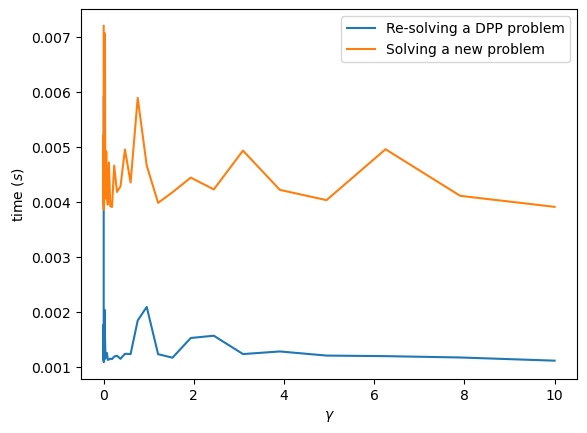

In [49]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

n = 15
m = 10

rng = np.random.default_rng(1)
A = rng.standard_normal((n, m))
b = rng.standard_normal(n)
# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)

objective = cp.Minimize(error + gamma * cp.norm(x, 1))
prob = cp.Problem(objective)
assert prob.is_dcp(dpp=True)

times = []
new_problem_times = []
gamma_vals = np.logspace(-4, 1)
for val in gamma_vals:
    gamma.value = val
    start = time.time()
    prob.solve()
    end = time.time()
    times.append(end - start)
    new_prob = cp.Problem(objective)
    start = time.time()
    new_prob.solve()
    end = time.time()
    new_problem_times.append(end - start)

_, ax = plt.subplots()
ax.plot(gamma_vals, times, label="Re-solving a DPP problem")
ax.plot(gamma_vals, new_problem_times, label="Solving a new problem")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("time ($s$)")
ax.legend();

### Sensitivity analysis and gradients

An optimization problem can be viewed as a function mapping parameters to solutions. This solution map is sometimes differentiable. CVXPY has built-in support for computing the derivative of the optimal variable values of a problem with respect to small perturbations of the parameters (i.e., the `Parameter` instances appearing in a problem).

The problem class exposes two methods related to computing the derivative. The `derivative` evaluates the derivative given perturbations to the parameters. This lets you calculate how the solution to a problem would change given small changes to the parameters, without re-solving the problem. The `backward` method evaluates the adjoint of the derivative, computing the gradient of the solution with respect to the parameters. This can be useful when combined with automatic differentiation software.

The derivative and backward methods are only meaningful when the problem contains parameters. In order for a problem to be differentiable, it must be DPP-compliant. CVXPY can compute the derivative of any DPP-compliant DCP or DGP problem. At non-differentiable points, CVXPY computes a heuristic quantity.

#### Example.
As a first example, we solve a trivial problem with an analytical solution, to illustrate the usage of the `backward` and `derivative` functions. In the following block of code, we construct a problem with a scalar variable x and a scalar parameter p. The problem is to minimize the quadratic `(x - 2*p)**2`.

In [50]:
import cvxpy as cp

x = cp.Variable()
p = cp.Parameter()
quadratic = cp.square(x - 2 * p)
prob = cp.Problem(cp.Minimize(quadratic))

Next, we solve the problem for the particular value of `p == 3`. Notice that when solving the problem, we supply the keyword argument `requires_grad=True` to the `solve` method.

__NOTE:__ We need to install the following packages.

```
conda install pybind11 threadpoolctl -c conda-forge
pip install diffcp
```

In [51]:
p.value = 3.
prob.solve(requires_grad=True)

2.8398992587956425e-29

Having solved the problem with `requires_grad=True`, we can now use the `backward` and `derivative` to differentiate through the problem. First, we compute the gradient of the solution with respect to its parameter by calling the `backward()` method. As a side-effect, the `backward()` method populates the `gradient` attribute on all parameters with the gradient of the solution with respect to that parameter.

In this case, the problem has the trivial analytical solution `2 * p`, and the gradient is therefore just 2.

In [52]:
prob.backward()
print(f"The gradient is {p.gradient:0.1f}.")

The gradient is 2.0.


Next, we use the `derivative` method to see how a small change in `p` would affect the solution `x`. We will perturb `p` by `1e-5`, by setting `p.delta = 1e-5`, and calling the `derivative` method will populate the `delta` attribute of `x` with the the change in `x` predicted by a first-order approximation (which is `dx/dp * p.delta`).

In this case the solution is trivial and its derivative is just `2 * p`, so we know that the delta in `x` should be `2e-5`.

In [55]:
p.delta = 1e-5
prob.derivative()
print(f"x.delta is {x.delta:2.1g}.")

x.delta is 2e-05.


We emphasize that this example is trivial, because it has a trivial analytical solution, with a trivial derivative. The `backward()` and `forward()` methods are useful because the vast majority of convex optimization problems do not have analytical solutions: in these cases, CVXPY can compute solutions and their derivatives, even though it would be impossible to derive them by hand.

__Note.__ In this simple example, the variable x was a scalar, so the `backward` method computed the gradient of `x` with respect to `p`. When there is more than one scalar variable, by default, `backward` computes the gradient of the sum of the optimal variable values with respect to the parameters.

More generally, the `backward` method can be used to compute the gradient of a scalar-valued function f of the optimal variables, with respect to the parameters. If `x(p)` denotes the optimal value of the variable (which might be a vector or a matrix) for a particular value of the parameter `p` and `f(x(p))` is a scalar, then `backward` can be used to compute the gradient of f with respect to `p`. Let `x* = x(p)`, and say the derivative of `f` with respect to `x*` is `dx`. To compute the derivative of `f` with respect to `p`, before calling `prob.backward()`, just set `x.gradient = dx`.

The `backward` method can be powerful when combined with software for automatic differentiation. We recommend the software package [CVXPY Layers](https://www.github.com/cvxgrp/cvxpylayers), which provides differentiable PyTorch and TensorFlow wrappers for CVXPY problems.

__backward or derivative?__ The `backward` method should be used when you need the gradient of (a scalar-valued function) of the solution, with respect to the parameters. If you only want to do a sensitivity analysis, that is, if all you’re interested in is how the solution would change if one or more parameters were changed, you should use the `derivative` method. When there are multiple variables, it is much more efficient to compute sensitivities using the `derivative` method than it would be to compute the entire Jacobian (which can be done by calling backward multiple times, once for each standard basis vector).